In [1]:
import enum
from pathlib import Path
import pickle
import typing

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shap
from sklearn import base, ensemble, metrics, model_selection, preprocessing, svm, feature_selection, neighbors
import strenum
import tqdm
import xgboost

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
T = typing.TypeVar('T')

In [3]:
root_path = Path("./")
all_paths = {
    "model": root_path.joinpath("models"),
    "image": root_path.joinpath("images"),
    "best_param": root_path.joinpath("best_params"),
    "shap_value": root_path.joinpath("shap_values"),
    "data": root_path.joinpath(".")
}
for path in all_paths.values():
    path.mkdir(exist_ok=True, parents=True)

In [4]:
def remove_outliers(data: pd.Series) -> list[int]:
    mu = data.mean()
    sigma = data.std()
    outliers_index = [i for i,x in enumerate(data) if x > (mu + 4*sigma) or x < (mu - 4*sigma)]
    
    return outliers_index

In [144]:
long_keys = [
    "Temperature",
    "Dissolved Oxygen",
    "pH",
    "Conductivity",
    "Biochemical Oxygen Demand",
    "Nitrate Nitrite Conc",
    "Fecal Coliform",
    "Total Coliform",
]
data_path = all_paths["data"].joinpath("WQ 2012_2021.csv")
train_df = (
    pd.read_csv(data_path)
    .query("YEAR != 2021")
    .dropna()
    .iloc[:, 7::3]
    .reset_index(drop=True)
)
train_df.columns = long_keys
outliers = []
for col in train_df.columns:
    outliers.extend(remove_outliers(train_df[col]))
train_df = train_df.drop(outliers).reset_index(drop=True)

train_df[long_keys] = preprocessing.MinMaxScaler().fit_transform(train_df)

test_df = (
    pd.read_csv(f"./WQ 2012_2021.csv")
    .dropna()
    .query("YEAR == 2021")
    .drop(columns=["CODE", "LOCATION", "YEAR"])
    .bfill()
    .groupby(["RIVER", "STATE"])
    .mean()
    # .iloc[:, 2::3]
    .filter(axis=1, like="AVG")
    # .reset_index(drop=True)
)
test_df.columns = long_keys
test_df[long_keys] = preprocessing.MinMaxScaler().fit_transform(test_df)

short_keys = test_df.columns.to_list()
short2long = {k: v for k, v in zip(short_keys, long_keys)}
long2short = {v: k for k, v in short2long.items()}

In [147]:
test_df

Temperature  Dissolved Oxygen        pH  \
RIVER       STATE                                                       
BEAS        HIMACHAL PRADESH     0.169923          0.812913  0.318871   
            PUNJAB               0.693777          0.679279  0.620661   
BRAHMAPUTRA ASSAM                0.754123          0.588370  0.072126   
CAUVERY     KARNATAKA            0.671650          0.458739  0.705124   
            TAMIL NADU           1.000000          0.387130  0.000000   
GANGA       BIHAR                0.627432          0.716905  0.506320   
            UTTAR PRADESH        0.706250          0.794277  0.473991   
            UTTARAKHAND          0.251235          1.000000  0.267769   
            WEST BENGAL          0.839535          0.436680  0.421488   
GODAVARI    ANDHRA PRADESH       0.892218          0.569884  0.231405   
            MAHARASHTRA          0.606051          0.322195  0.308790   
            TELANGANA            0.883438          0.257143  0.450413   
KRISHNA     ANDHRA PRADESH       0.777095          0.465065  0.359045   
            KARNATAKA            0.936121          0.510682  1.000000   
            MAHARASHTRA          0.890846          0.336937  0.487603   
            TELANGANA            0.564702          0.300901  0.175207   
MAHANADI    CHHATTISGARH         0.788432          0.529730  0.614876   
            ODISHA               0.751485          0.642242  0.375115   
SATLUJ      HIMACHAL PRADESH     0.000000          0.877477  0.540634   
            PUNJAB               0.447152          0.297898  0.482782   
YAMUNA      DELHI                0.626166          0.000000  0.441322   
            HARYANA              0.907535          0.272873  0.204775   
            HIMACHAL PRADESH     0.447920          0.686486  0.429752   
            UTTAR PRADESH        0.912359          0.378604  0.552686   
            UTTARAKHAND          0.155965          0.978378  0.233058   

                              Conductivity  Biochemical Oxygen Demand  \
RIVER       STATE                                                       
BEAS        HIMACHAL PRADESH      0.008597                   0.000000   
            PUNJAB                0.053176                   0.009391   
BRAHMAPUTRA ASSAM                 0.009157                   0.045217   
CAUVERY     KARNATAKA             0.027858                   0.027757   
            TAMIL NADU            0.179958                   0.031180   
GANGA       BIHAR                 0.065934                   0.045217   
            UTTAR PRADESH         0.062218                   0.063018   
            UTTARAKHAND           0.020156                   0.009507   
            WEST BENGAL           0.497268                   0.059379   
GODAVARI    ANDHRA PRADESH        0.039981                   0.028075   
            MAHARASHTRA           0.203810                   0.103399   
            TELANGANA             0.109549                   0.050932   
KRISHNA     ANDHRA PRADESH        1.000000                   0.045411   
            KARNATAKA             0.264937                   0.041491   
            MAHARASHTRA           0.131211                   0.090435   
            TELANGANA             0.236180                   0.056000   
MAHANADI    CHHATTISGARH          0.070744                   0.026087   
            ODISHA                0.519049                   0.010531   
SATLUJ      HIMACHAL PRADESH      0.596802                   0.001159   
            PUNJAB                0.109323                   0.404565   
YAMUNA      DELHI                 0.374652                   1.000000   
            HARYANA               0.181461                   0.359420   
            HIMACHAL PRADESH      0.191333                   0.017043   
            UTTAR PRADESH         0.332114                   0.676304   
            UTTARAKHAND           0.000000                   0.002783   

                              Nitrate Nitrite Conc  Fecal Coliform  \
RIVER       STAT

In [45]:
class Models(strenum.StrEnum):
    SVM = enum.auto()
    XGB = enum.auto()
    RF = enum.auto()
    GB = enum.auto()

class Parameters(strenum.StrEnum):
    T = "Temperature"
    DO = "Dissolved Oxygen"
    PH = "pH"
    COND = "Conductivity"
    BOD = "Biochemical Oxygen Demand"
    N = "Nitrate Nitrite Conc"
    FC = "Fecal Coliform"
    TC = "Total Coliform"


model_params: dict[Models, dict[typing.Literal['fixed', 'tuning', 'other'], dict[str, str | int | float | bool | list]]] = {
    Models.GB: {
        "fixed": {
            "loss": "squared_error",
            "random_state": 0,
            "max_depth": 10,
            "subsample": 0.5,
        },
        "tuning": {
            "n_estimators": [1000, 3000, 4500],
            "learning_rate": [0.01, 0.001, 0.1],
        },
    },
    Models.RF: {
        "fixed": {
            "max_depth": 10,
            "random_state": 0,
            "max_samples": 0.5,
            "criterion": "squared_error",
        },
        "tuning": {
            "n_estimators": [1000, 3000, 5000],
        },
    },
    Models.XGB: {
        "fixed": {
            "random_state": 0,
            "subsample": 0.5,
        },
        "tuning": {
            "n_estimators": [5000, 7500, 10000, 15000, 20000],
            "learning_rate": [0.01, 0.1, 0.001],
        },
        "other": {
            "early_stopping_rounds": 50,
            "eval_metric": metrics.mean_squared_error,
        }
    },
    Models.SVM : {
        "fixed": {},
        "tuning": {}
    }
}

estimators: dict[Models, type[ensemble.GradientBoostingRegressor] | type[ensemble.RandomForestRegressor] | type[svm.SVR] | type[xgboost.XGBRegressor]] = {
    Models.GB: ensemble.GradientBoostingRegressor,
    Models.RF: ensemble.RandomForestRegressor,
    Models.SVM: svm.SVR,
    Models.XGB: xgboost.XGBRegressor,
}

In [46]:
def read_pkl(pkl_path: Path):
    with open(pkl_path, 'rb') as pkl:
        return pickle.load(pkl)
    
def write_pkl(python_obj: any, pkl_path: Path):
    assert pkl_path.suffix == '.pkl', 'Path does not point to a .pkl file.'
    pkl_path.parent.mkdir(exist_ok=True, parents=True)
    
    with open(pkl_path, 'wb') as pkl:
        return pickle.dump(python_obj, pkl, protocol=pickle.HIGHEST_PROTOCOL)
    
def file_exists(file_path_s: Path | list[Path] | typing.Iterator[Path])->tuple[list[Path],list[Path]]:
    exists = []
    not_exists = []
    if isinstance(file_path_s, Path):
        return ([file_path_s],[]) if file_path_s.exists() else ([],[file_path_s])
    for f_path in file_path_s:
        if f_path.exists():
            exists.append(f_path)
        else:
            not_exists.append(f_path)
    return exists, not_exists

def literal_to_list(abc: T) -> typing.List[T]:
    if abc is None:
        return []
    if not (isinstance(abc, enum.EnumType) or isinstance(abc, list)): return [abc]
    return abc

In [47]:
def get_train_data(df:pd.DataFrame, target_name: Parameters, validation_split: None | float | int = None, exclude: None | Parameters | list[Parameters] = None):
    if exclude is None:exclude = []
    if not (isinstance(exclude, list) or isinstance(exclude, enum.EnumType)): exclude = [exclude]  
    X = df.drop(columns=[target_name, *exclude])
    y = df[target_name]
    if validation_split:
        assert 0<validation_split<1 or (isinstance(validation_split, int) and 0 < validation_split < 100), "validation split must be between 0..1 or 0..100."
        return model_selection.train_test_split(X,y, test_size=validation_split, random_state=0)
    return X,y

def get_test_data(df:pd.DataFrame, target_name: Parameters, exclude: None | Parameters | list[Parameters] = None):
    if exclude is None:exclude = []
    if not (isinstance(exclude, list) or isinstance(exclude, enum.EnumType)): exclude = [exclude]  
    X = df.drop(columns=[target_name, *exclude])
    y = df[target_name]
    return X,y

In [48]:
OVERWRITE = True

In [49]:
def get_fineduned_model_params(
    model_name: Models,
    estimator: base.BaseEstimator,
    unknown: dict[str, typing.Any],
    sample_percent: float,
    train_df: pd.DataFrame,
    train_param: Parameters | list[Parameters],
    excludes: None | Parameters | list[Parameters],
    opt_path: Path = None,
    read_cache: bool = True,
):
    if excludes is not None:
        excludes = literal_to_list(excludes)
    else:
        excludes = []
    train_param = literal_to_list(train_param)

    if unknown.items().__len__() < 1:
        return {}.fromkeys(long_keys, {})

    reg = model_selection.GridSearchCV(
        estimator=estimator, cv=5, n_jobs=5, verbose=0, param_grid=unknown
    )

    best_model_params = {}

    
    if read_cache and not OVERWRITE:
        for param in train_param:
            best_model_params[param] = read_pkl(
                all_paths["best_param"].joinpath(opt_path or "", model_name, f"{param}.pkl")
            )
            # best_model_params[param] = read_pkl(f"best_params/{model_name}/{param}.pkl")
        return best_model_params

    param_find_df = train_df.sample(frac=sample_percent).reset_index(drop=True)
    total_itr = len(train_param)
    for index, target in (
        pbar := tqdm.tqdm(
            enumerate(train_param),
            desc="Fine-tuing for",
            bar_format="{desc}",
        )
    ):
        pbar.set_description_str(
            f"Fine-tuning for {target}. Completed: ({index}/{total_itr})."
        )
        reg.fit(
            param_find_df.drop(columns=[target, *excludes]),
            param_find_df[target],
        )
        best_model_params[target] = reg.best_params_
        write_pkl(
            python_obj=reg.best_params_,
            pkl_path=Path(
                all_paths["best_param"].joinpath(opt_path or "", model_name, f"{target}.pkl"),
            ),
            # pkl_path=Path(f"best_params/{model_name}/{target}.pkl"),
        )
        pbar.set_description_str(
            f"Fine-tuning for {target}. Completed: ({index+1}/{total_itr})."
        )

    return best_model_params

In [50]:
def get_full_model_params(fixed_model_params: dict[str,typing.Any], tuned_model_params:dict[str,typing.Any], other_params: dict[str,typing.Any] = {}):
    return {k:v for k,v in {**fixed_model_params, **tuned_model_params, **other_params}.items()}

In [51]:
def save_models(save_folder: Path, models_collection: dict[Models, dict[Parameters, base.BaseEstimator]]):
    for model_name, models_dict in models_collection.items():
        for target, model in models_dict.items():
            write_pkl(model, save_folder.joinpath(f"{model_name}/{target.replace('/',' ')}.pkl"))

def load_models(model_name: Models, target_s: Parameters | list[Parameters], save_folder: Path):
    models: dict[Parameters, base.BaseEstimator] = {}
    target_s = literal_to_list(target_s)
    for target in target_s:
        models[target] = read_pkl(pkl_path=save_folder.joinpath(f"{model_name}/{target}.pkl"))
    return models

In [52]:
def train(
    model_name: Models,
    target_s: Parameters | list[Parameters],
    sample_percent: float,
    other_params: dict[str, typing.Any] = {},
    exclude_params: None | Parameters | list[Parameters] = None,
    read_cache: bool = True,
    cache_path: Path = all_paths['model'].joinpath("optimized")
):
    models = {}
    if exclude_params is not None: exclude_params = literal_to_list(exclude_params) 
    else: exclude_params = []
    target_s = literal_to_list(target_s)
    exists, not_exists = file_exists([cache_path.joinpath(f"{model_name}/{t}.pkl") for t in target_s])
    exists = [p.stem for p in exists]
    not_exists = [p.stem for p in not_exists if exclude_params.count(p.stem) < 1]

    if read_cache and not OVERWRITE:
        print("Reading from Cache...")
        models = load_models(model_name, exists, cache_path)

    print(f"TRAINING {model_name}....")
    est = estimators[model_name]
    
    assert 0 <= sample_percent <= 1, "Sample percent must be in 0..1"
    finetuned = get_fineduned_model_params(
        model_name=model_name,
        estimator=est(**model_params[model_name]["fixed"]),
        unknown=model_params[model_name]["tuning"],
        sample_percent=sample_percent,
        train_df=train_df,
        train_param=not_exists,
        excludes=exclude_params,
        read_cache=read_cache,
        opt_path=cache_path.relative_to(all_paths['model'])
    )
    full_model_params = {}
    for param_name, f_model_params in finetuned.items():
        full_model_params[param_name] = get_full_model_params(
            model_params[model_name]["fixed"], f_model_params, other_params
        )

    total_itr = len(list(full_model_params.keys()))
    for index, (param_name, parameters) in (
        pbar := tqdm.tqdm(
            enumerate(full_model_params.items()),
            desc="\tTraining for",
            bar_format="{desc}",
        )
    ):
        pbar.set_description_str(f"\tTraining for {param_name} {index + 1}/{total_itr}")
        reg = est(**parameters)
        if model_name == Models.XGB:
            X_train, X_eval, y_train, y_eval = get_train_data(
                df=train_df,
                target_name=param_name,
                validation_split=0.2,
                exclude=exclude_params,
            )
            reg.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], verbose=0)
        else:
            X_train, y_train = get_train_data(
                df=train_df, target_name=param_name, exclude=exclude_params
            )
            reg.fit(X_train, y_train)
        models[param_name] = reg

    return models

In [53]:
def train_models(
    exclude_params: None | Parameters | list[Parameters],
    include_models: tuple[bool, Models | list[Models]],
    sample_percent: float,
    save: None | Path = None,
):
    if include_models[0]:
        model_names = set(literal_to_list(include_models[1]))
    else:
        model_names = set(Models).difference(set(literal_to_list(include_models[1])))
    models = {}
    if exclude_params is not None:
        exclude_params = literal_to_list(exclude_params)
    else:
        exclude_params = []
    for model_name in model_names:
        models[model_name] = train(
            model_name,
            exclude_params=exclude_params,
            target_s=list(set(Parameters) - set(exclude_params)),
            sample_percent=sample_percent,
            other_params=model_params.get(model_name).get("other") or {},
            cache_path=save,
            read_cache=False,
        )

    if save:
        save_models(save, models)

In [54]:
variant = "outliers-removed/omitted/FC"

In [55]:
# for model_name in Models:
train_models(Parameters.FC, (True, [Models.RF, Models.XGB]), 1, all_paths['model'].joinpath(variant))

TRAINING XGB....


Fine-tuning for Nitrate Nitrite Conc. Completed: (4/7).     A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
Fine-tuning for pH. Completed: (7/7).                  
	Training for pH 7/7                       


TRAINING RF....


Fine-tuning for pH. Completed: (7/7).                       
	Training for pH 7/7                       


In [18]:
def shap_func(config, train_df, only_values=False, save_plot=False):
    assert config['path'].joinpath(config['model_name']).exists(), "model not found in path." 
    path = all_paths['shap_value'].joinpath("/".join(config['path'].parts[1:]))
    path.mkdir(exist_ok=True, parents=True)
    path = path.joinpath(config['model_name'], f"{config['target_name']}.pkl")
    X_train, *_ = get_train_data(train_df, config['target_name'], exclude=config['excluded_params'], validation_split=0.2 if config['model_name'] == Models.XGB else None)
    model = load_models(config['model_name'], config['target_name'], config['path'])[config['target_name']]
    explainer = shap.Explainer(model, X_train)
    if path.exists(): shap_value = read_pkl(path)
    else:
        # explainer = shap.Explainer(lambda x: model.predict(x), X_train)
        shap_value = explainer(X_train)
        write_pkl(shap_value,path)

    def save_plot(type:typing.Literal['bar','summary','beeswarm']):
        image_path = all_paths['image'].joinpath(type,"/".join(config['path'].parts[1:])).joinpath(config['model_name'], f"{config['target_name']}.jpg")
        image_path.parent.mkdir(exist_ok=True, parents=True)
        plt.savefig(image_path, bbox_inches='tight')
    
    if not only_values:

        plt.title(config['target_name'])
        shap.summary_plot(shap_value, X_train, alpha=.4, show=not save_plot)
        if save_plot: save_plot("summary")
        plt.show()
        
        plt.title(config['target_name'])
        shap.summary_plot(shap_value, X_train, plot_type="violin", show=not save_plot)
        if save_plot: save_plot("violin")
        plt.show()

        plt.title(config['target_name'])
        shap.plots.bar(shap_value, show=not save_plot)
        if save_plot: save_plot("bar")
        plt.show()
        
        force_plot = shap.force_plot(explainer.expected_value, shap_value.values, X_train)
        html_path = all_paths['image'].joinpath('force',"/".join(config['path'].parts[1:])).joinpath(config['model_name'], f"{config['target_name']}.html")
        html_path.parent.mkdir(exist_ok=True, parents=True)
        shap.save_html(html_path.__str__(), force_plot)
        
    return shap_value

100%|===================| 1567/1570 [09:58<00:01]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


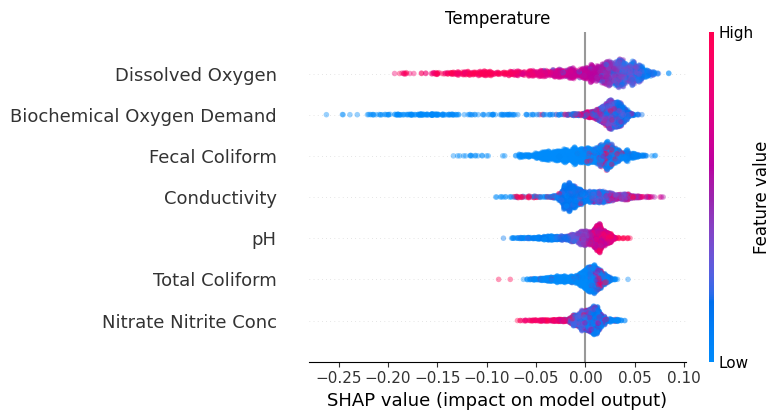

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


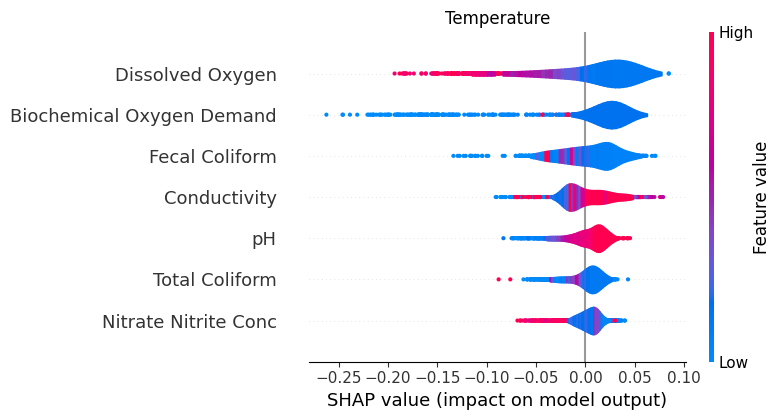

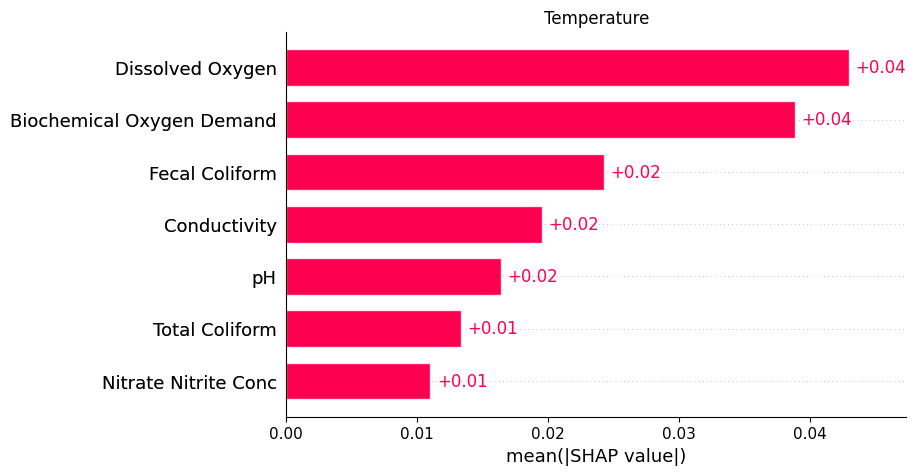

 99%|===================| 1560/1570 [00:52<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


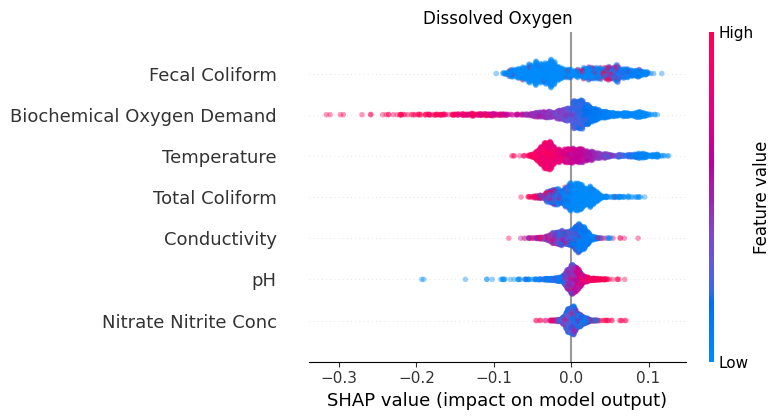

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


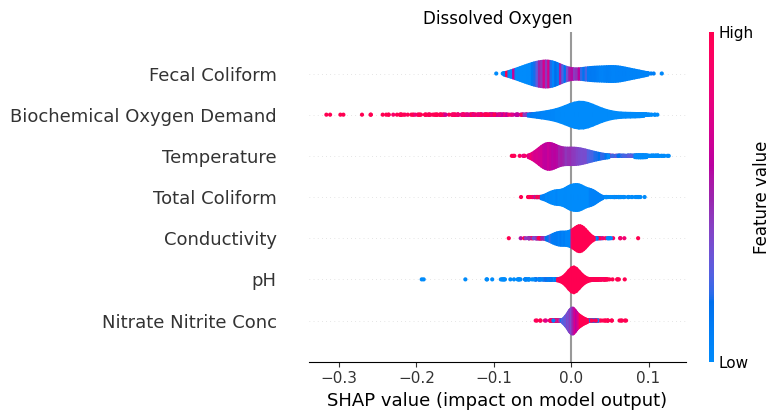

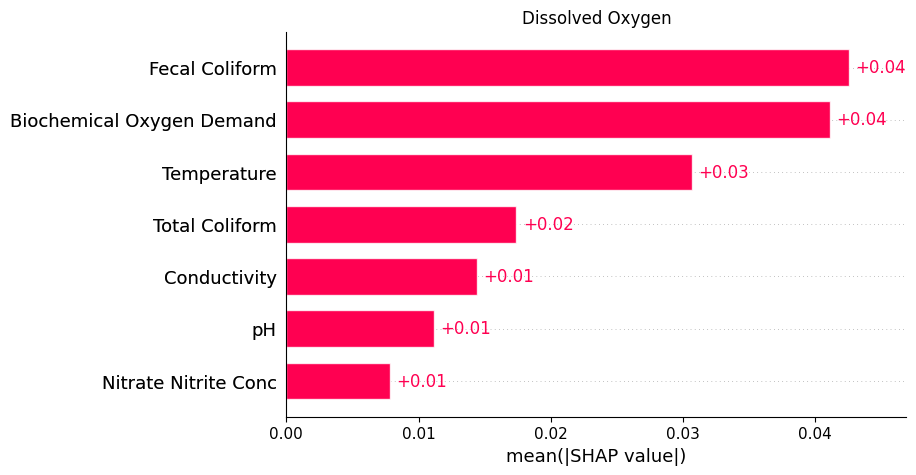

100%|===================| 1568/1570 [07:32<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


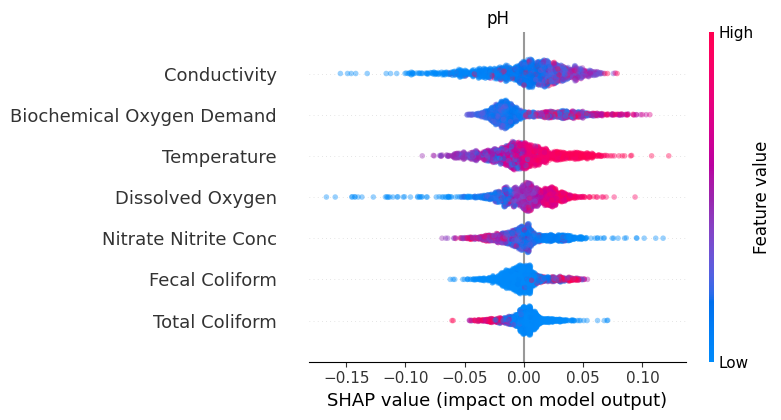

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


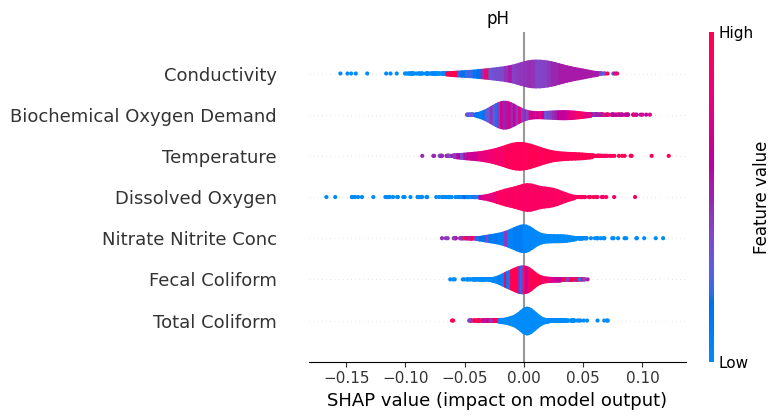

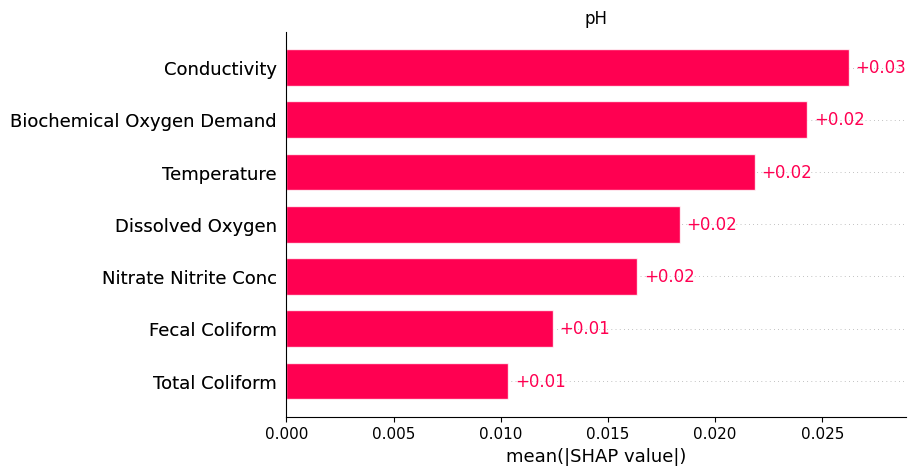

100%|===================| 1567/1570 [02:32<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


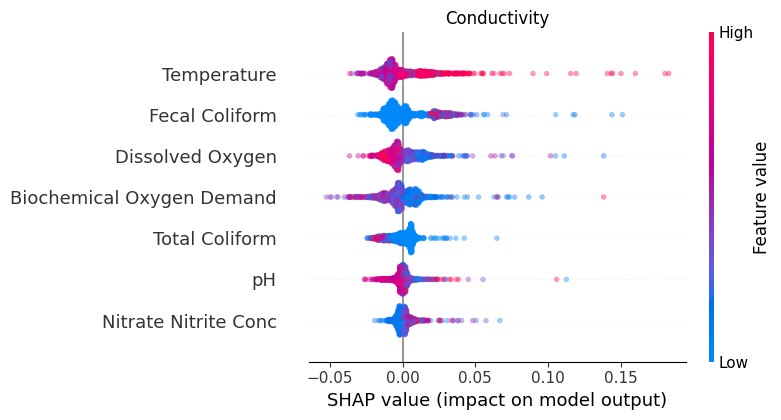

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


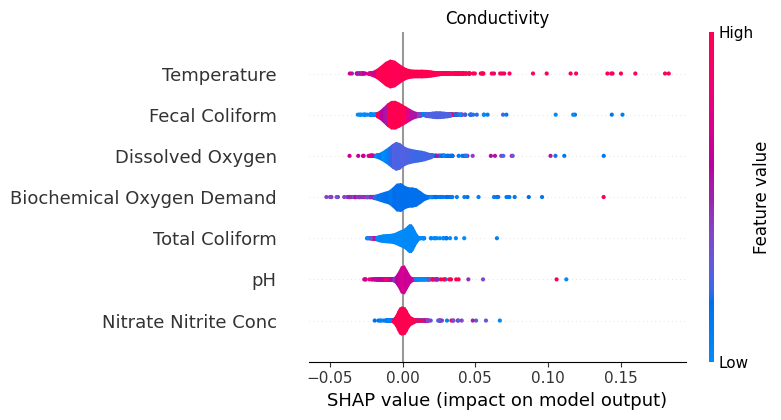

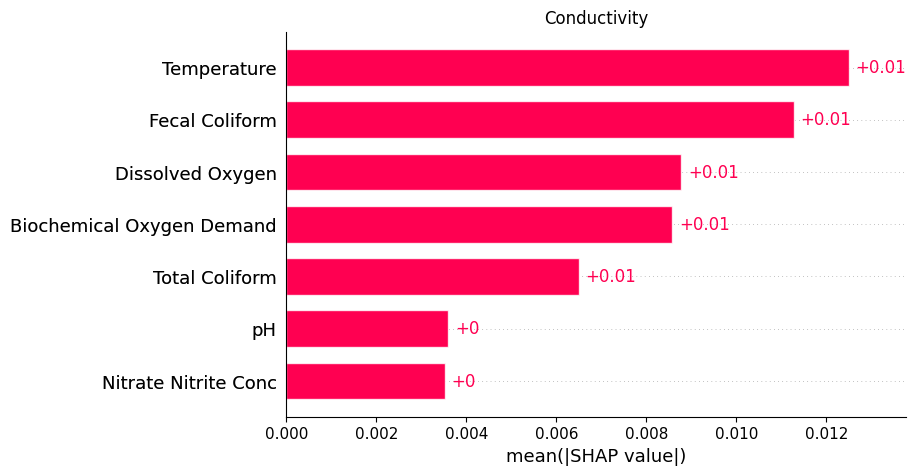

100%|===================| 1567/1570 [06:44<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


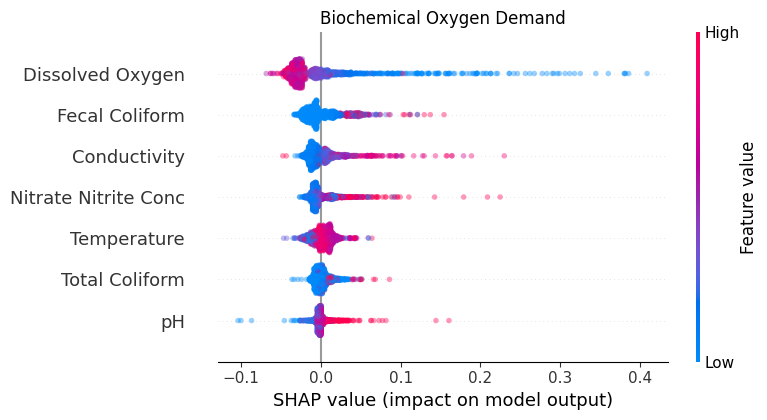

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


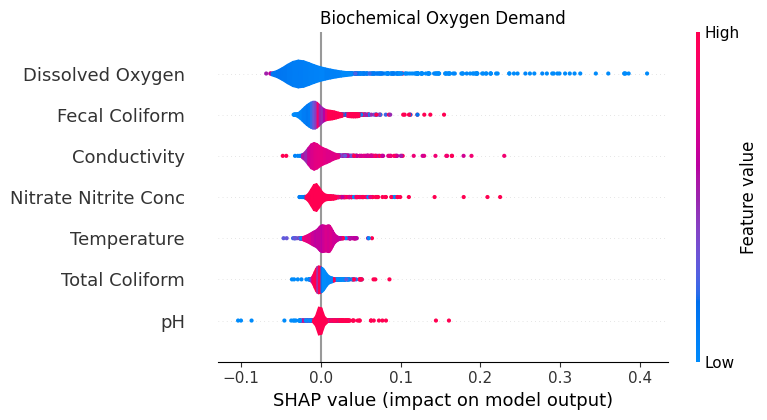

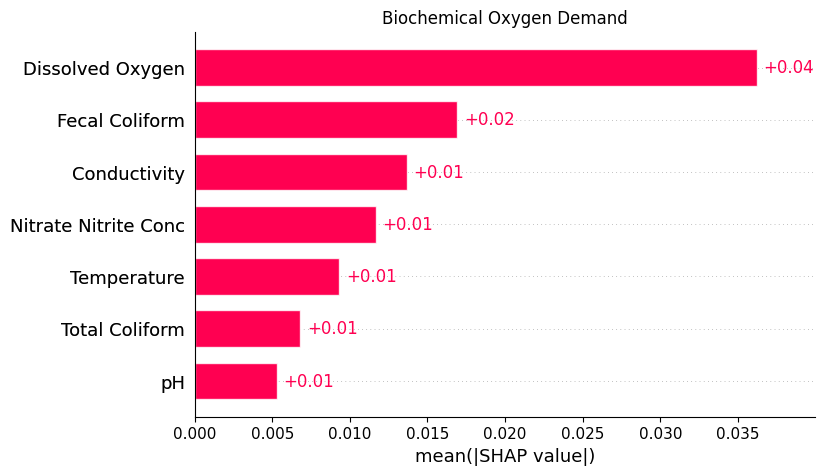

100%|===================| 1567/1570 [07:54<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


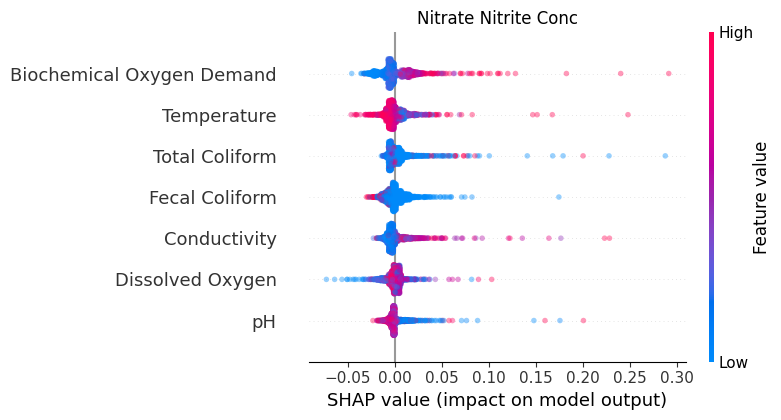

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


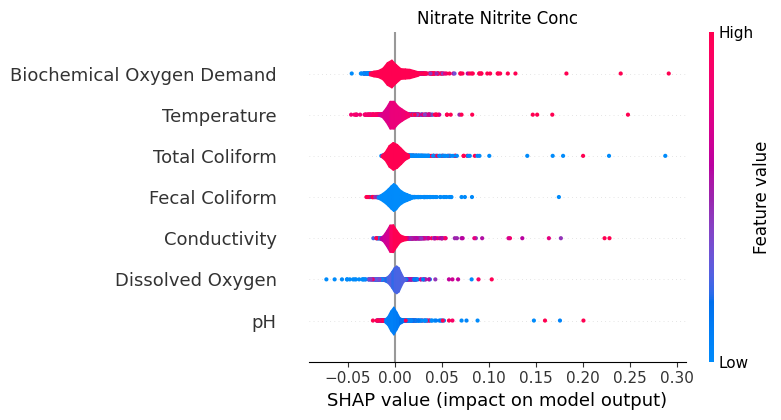

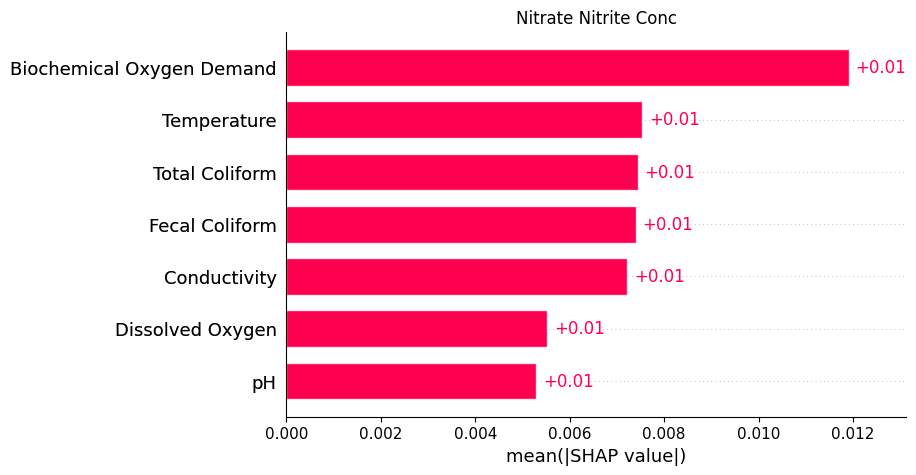

 99%|===================| 1559/1570 [00:45<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


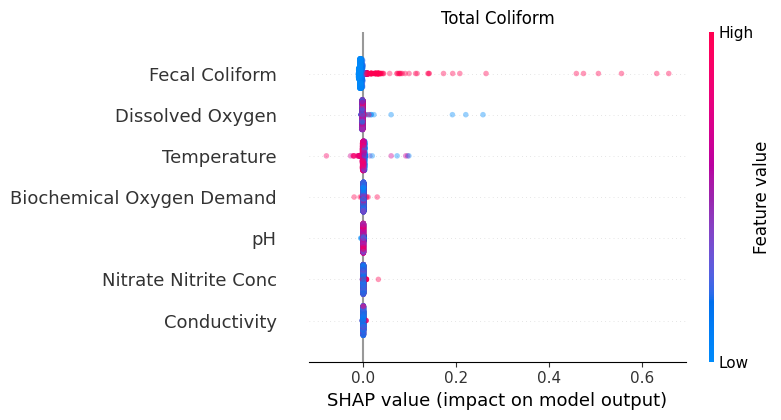

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


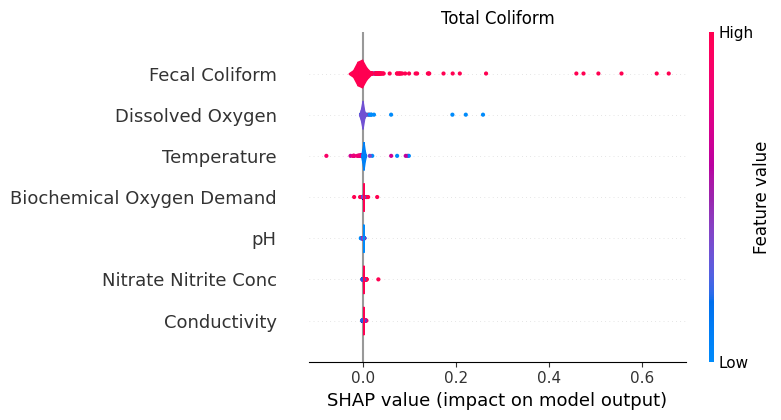

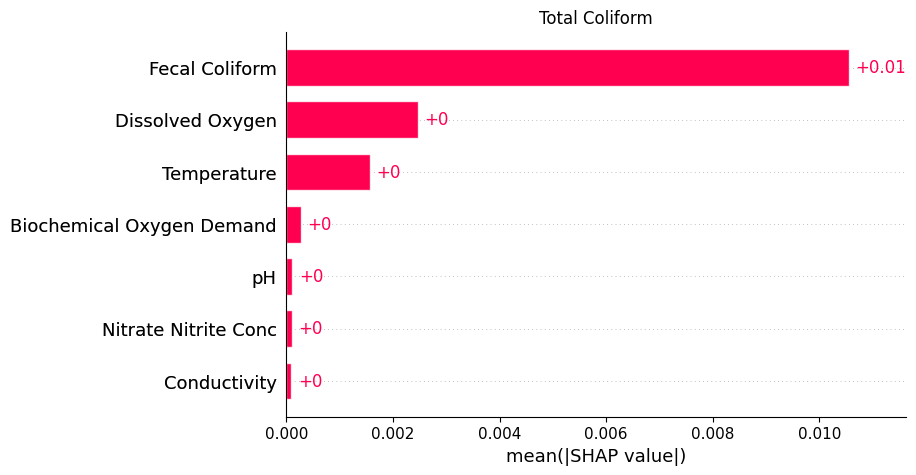

In [21]:
# model = load_models(Models.XGB, Parameters.T.value, Path("models/omitted/FC"))[Parameters.T.value]
# X_train, _ = get_train_data(train_df, Parameters.T, exclude=Parameters.FC)
for target_name in Parameters:
    if target_name is not Parameters.FC:
        shap_func({
                "model_name": Models.XGB,
                "target_name": target_name,
                "excluded_params": None,
                "path": all_paths['model'].joinpath(variant),
                "explainer": shap.TreeExplainer
            },
            train_df, save_plot=True)

In [175]:
def test(test_df: pd.DataFrame, target_name: Parameters, model_path: Path) -> dict[typing.Literal["mean_squared_error"],float]:
    X_test, y_test = get_test_data(df=test_df, target_name=target_name)
    model = read_pkl(pkl_path=model_path)
    y_predict = model.predict(X_test)
    return {
        "mean_squared_error": metrics.mean_squared_error(y_pred=y_predict, y_true=y_test) 
    }

In [183]:
# test(test_df, Parameters.DO, 
#     )
all_paths["model"].joinpath(variant, Models.XGB, Parameters.DO)

TypeError: 'str' object is not callable

In [ ]:
# mse = {}
# for target_name in Parameters:
#     rse = {}
#     for model_name in Models:
#         # if target_name == Parameters.FC.value: continue
#         model_name = model_name.value
#         rse[model_name] = test(test_df=test_df, model_path=Path(f"./models/omiited/FC/{model_name}/{target_name}.pkl"), target_name=target_name)['mean_squared_error']
#     mse[target_name] = rse

In [ ]:
# # levels = [.5,.25,.125,.0625]
# n = 4
# levels = [.4,.3,.2,.1]

# def replace_conditional(row: pd.Series, selected_model):
#     res = 0
#     for lvl in range(n):
#         if row.name == lvl:
#             res += ((row == selected_model).astype(int) * levels[lvl]).sum()
#     return res


# compare_model = pd.DataFrame(
#     {
#         i: {col: pd.DataFrame(mse)[col].nsmallest(n).index[i] for col in long_keys}
#         for i in range(n)
#     }
# )

# rank = {}
# for selected_model in Models:
#     rank[selected_model] = (
#         compare_model.transpose()
#         .apply(lambda x: replace_conditional(x, selected_model), axis=1)
#         .sum()
#     )
# rank = [
#     k.value for k, _ in sorted(rank.items(), key=lambda item: item[1], reverse=True)
# ]

In [ ]:
# compare_model.transpose()

In [184]:
eval_df = (
    pd.read_csv(all_paths["data"].joinpath("WQ 2012_2021.csv")).dropna()
    .drop(columns=["CODE", "LOCATION"])
    .query("YEAR==2021")
    .drop(columns=["YEAR"])
    .groupby(["RIVER", "STATE"])
    .mean()
    .filter(axis=1, like="AVG")
)
eval_df.columns = long_keys
cols = eval_df.columns
eval_df[cols] = preprocessing.MinMaxScaler().fit_transform(eval_df)
eval_df

Temperature  Dissolved Oxygen        pH  \
RIVER       STATE                                                       
BEAS        HIMACHAL PRADESH     0.169923          0.812913  0.318871   
            PUNJAB               0.693777          0.679279  0.620661   
BRAHMAPUTRA ASSAM                0.754123          0.588370  0.072126   
CAUVERY     KARNATAKA            0.671650          0.458739  0.705124   
            TAMIL NADU           1.000000          0.387130  0.000000   
GANGA       BIHAR                0.627432          0.716905  0.506320   
            UTTAR PRADESH        0.706250          0.794277  0.473991   
            UTTARAKHAND          0.251235          1.000000  0.267769   
            WEST BENGAL          0.839535          0.436680  0.421488   
GODAVARI    ANDHRA PRADESH       0.892218          0.569884  0.231405   
            MAHARASHTRA          0.606051          0.322195  0.308790   
            TELANGANA            0.883438          0.257143  0.450413   
KRISHNA     ANDHRA PRADESH       0.777095          0.465065  0.359045   
            KARNATAKA            0.936121          0.510682  1.000000   
            MAHARASHTRA          0.890846          0.336937  0.487603   
            TELANGANA            0.564702          0.300901  0.175207   
MAHANADI    CHHATTISGARH         0.788432          0.529730  0.614876   
            ODISHA               0.751485          0.642242  0.375115   
SATLUJ      HIMACHAL PRADESH     0.000000          0.877477  0.540634   
            PUNJAB               0.447152          0.297898  0.482782   
YAMUNA      DELHI                0.626166          0.000000  0.441322   
            HARYANA              0.907535          0.272873  0.204775   
            HIMACHAL PRADESH     0.447920          0.686486  0.429752   
            UTTAR PRADESH        0.912359          0.378604  0.552686   
            UTTARAKHAND          0.155965          0.978378  0.233058   

                              Conductivity  Biochemical Oxygen Demand  \
RIVER       STATE                                                       
BEAS        HIMACHAL PRADESH      0.008597                   0.000000   
            PUNJAB                0.053176                   0.009391   
BRAHMAPUTRA ASSAM                 0.009157                   0.045217   
CAUVERY     KARNATAKA             0.027858                   0.027757   
            TAMIL NADU            0.179958                   0.031180   
GANGA       BIHAR                 0.065934                   0.045217   
            UTTAR PRADESH         0.062218                   0.063018   
            UTTARAKHAND           0.020156                   0.009507   
            WEST BENGAL           0.497268                   0.059379   
GODAVARI    ANDHRA PRADESH        0.039981                   0.028075   
            MAHARASHTRA           0.203810                   0.103399   
            TELANGANA             0.109549                   0.050932   
KRISHNA     ANDHRA PRADESH        1.000000                   0.045411   
            KARNATAKA             0.264937                   0.041491   
            MAHARASHTRA           0.131211                   0.090435   
            TELANGANA             0.236180                   0.056000   
MAHANADI    CHHATTISGARH          0.070744                   0.026087   
            ODISHA                0.519049                   0.010531   
SATLUJ      HIMACHAL PRADESH      0.596802                   0.001159   
            PUNJAB                0.109323                   0.404565   
YAMUNA      DELHI                 0.374652                   1.000000   
            HARYANA               0.181461                   0.359420   
            HIMACHAL PRADESH      0.191333                   0.017043   
            UTTAR PRADESH         0.332114                   0.676304   
            UTTARAKHAND           0.000000                   0.002783   

                              Nitrate Nitrite Conc  Fecal Coliform  \
RIVER       STAT

In [185]:
model = load_models(model_name=Models.XGB, target_s=Parameters.DO, save_folder=all_paths["model"].joinpath(variant))[Parameters.DO]

In [186]:
X,y = get_test_data(df=eval_df, target_name=Parameters.DO, exclude=Parameters.FC)

In [187]:
abs(100 * (model.predict(X) - y) / y).sort_values()

RIVER        STATE           
MAHANADI     CHHATTISGARH          4.043177
GANGA        WEST BENGAL           4.125206
GODAVARI     ANDHRA PRADESH        5.210402
YAMUNA       UTTAR PRADESH         6.694967
             HARYANA               8.622025
KRISHNA      ANDHRA PRADESH       12.972680
YAMUNA       HIMACHAL PRADESH     17.378131
BRAHMAPUTRA  ASSAM                18.827819
GANGA        BIHAR                19.547842
SATLUJ       PUNJAB               20.346138
CAUVERY      TAMIL NADU           20.366459
BEAS         PUNJAB               20.686726
             HIMACHAL PRADESH     20.930595
MAHANADI     ODISHA               23.243873
KRISHNA      KARNATAKA            23.907516
YAMUNA       UTTARAKHAND          25.713578
SATLUJ       HIMACHAL PRADESH     26.820334
CAUVERY      KARNATAKA            28.888090
GANGA        UTTAR PRADESH        36.160279
             UTTARAKHAND          42.077023
GODAVARI     MAHARASHTRA          51.995905
KRISHNA      MAHARASHTRA          70.254660
  

In [188]:
result = pd.DataFrame({"actual":y, "observed":model.predict(X)})

In [189]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y,model.predict(X))

0.03371003577439899